## Домашняя работа 4. 

Максимальный балл за задание - 10.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\miniconsa\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'clf', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [16]:
import random

random.seed(690)

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [2]:
data = pd.read_csv("data.adult.csv")
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [3]:
shape = data.shape
shape

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
pd.isnull(data).sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

In [5]:
data = data.replace("?", np.nan)

In [6]:
pd.isna(data).sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [7]:
data = data.dropna(axis=0)
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


In [8]:
shape[0] - data.shape[0]

933

In [9]:
pd.isna(data).sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [10]:
y = data['>50K,<=50K'] # target
X = data.drop('>50K,<=50K', 1)

In [11]:
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4         >50K
         ...  
16275    <=50K
16276     >50K
16277    <=50K
16278    <=50K
16279     >50K
Name: >50K,<=50K, Length: 15347, dtype: object

In [12]:
y = (y == '>50K').astype('int')
y = y.to_numpy() # if necessary 
y

array([0, 0, 0, ..., 0, 0, 1])

In [13]:
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
data_num = data.select_dtypes(include=np.number)
X = data_num
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

**kNN**

In [17]:
param_grid = {'n_neighbors': [1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000, 15346]}
gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

C:\miniconsa\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\miniconsa\lib\site-packages\sklearn\metrics\_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\miniconsa\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\miniconsa\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\miniconsa\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), es

{'mean_fit_time': array([0.04278593, 0.04449415, 0.04477181, 0.04334211, 0.04648352,
        0.04332132, 0.04431667, 0.0391417 , 0.04091945, 0.0401958 ,
        0.00162106, 0.00645146]),
 'std_fit_time': array([0.0020054 , 0.0028823 , 0.00200104, 0.00317139, 0.00820635,
        0.00192334, 0.00620958, 0.00339159, 0.00314816, 0.00023938,
        0.00149542, 0.00547723]),
 'mean_score_time': array([0.0190938 , 0.02074895, 0.02380829, 0.02149477, 0.02892089,
        0.04912038, 0.07889833, 0.33010769, 0.73387256, 3.42755299,
        5.82982264, 0.        ]),
 'std_score_time': array([0.00107773, 0.00146578, 0.00092212, 0.00378721, 0.00670872,
        0.00284294, 0.00477873, 0.00473792, 0.04706099, 0.10087502,
        0.20671342, 0.        ]),
 'param_n_neighbors': masked_array(data=[1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000,
                    15346],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
      

In [18]:
print('kNN','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

kNN 
best parameters: {'n_neighbors': 5} 
best score: 0.6404401214740305


Лучшие значения скора лежат среди первых 5 параметров, поэтому увеличим точность и будем искать от 1 до 20.

In [19]:
param_grid = {'n_neighbors': [i for i in range(1, 21)]}
gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.0410337 , 0.04325986, 0.04664907, 0.04358735, 0.04457397,
        0.04142017, 0.04442244, 0.0394712 , 0.04052558, 0.04402833,
        0.03922272, 0.03913808, 0.03851681, 0.03881054, 0.04049792,
        0.0419692 , 0.04033904, 0.04446068, 0.04324141, 0.04457159]),
 'std_fit_time': array([6.16988296e-03, 7.80697904e-03, 2.75988010e-03, 7.14267788e-03,
        3.47950982e-03, 7.75923261e-03, 4.46052973e-03, 3.34989089e-03,
        1.02032411e-04, 3.38508417e-03, 1.57168965e-03, 4.22925617e-03,
        3.12567977e-03, 3.22834669e-03, 1.27890766e-04, 3.19191771e-03,
        4.38092177e-05, 5.32929018e-03, 4.44414686e-03, 6.00936291e-03]),
 'mean_score_time': array([0.01941252, 0.01693506, 0.02111878, 0.01802816, 0.01879487,
        0.02403545, 0.01624756, 0.02484303, 0.02232661, 0.02090955,
        0.02469897, 0.02453356, 0.02630477, 0.02629657, 0.02626967,
        0.02622075, 0.02988758, 0.02385178, 0.02946167, 0.02943296]),
 'std_score_time': array([0.00832959, 

In [20]:
print('KNN','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

KNN 
best parameters: {'n_neighbors': 4} 
best score: 0.6407170629127037


In [21]:
gridsearch.cv_results_['mean_test_score'] # will be used in graph later

array([0.6150689 , 0.63493223, 0.6362029 , 0.64071706, 0.64044012,
       0.63880401, 0.63795007, 0.63622886, 0.63647811, 0.63535991,
       0.63634341, 0.63556798, 0.63472055, 0.63207095, 0.62995551,
       0.63036858, 0.63041108, 0.62994346, 0.62874474, 0.62787913])

Text(0, 0.5, 'mean CV roc-auc score')

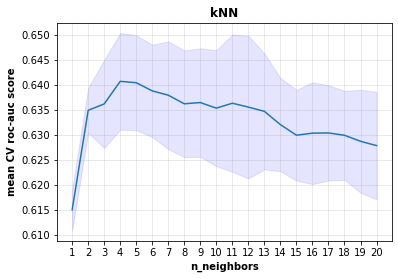

In [22]:
# https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python

x0 = [i for i in range(1, 21)]
x1 = gridsearch.cv_results_['mean_test_score']
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
ax.fill_between(x0, (x1-ci), (x1+ci), color='b', alpha=.1)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('kNN', weight='bold')
plt.xticks(x0)
plt.xlabel('n_neighbors', weight='bold')
plt.ylabel('mean CV roc-auc score', weight='bold')

**Decision Tree**

In [23]:
param_grid = {'max_depth': [1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000, 15346]}
gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.00579271, 0.00877109, 0.01497893, 0.02398715, 0.03252325,
        0.038025  , 0.04139638, 0.03736291, 0.03703995, 0.03679042,
        0.03734808, 0.04251003]),
 'std_fit_time': array([0.00040316, 0.00145626, 0.00489227, 0.00554901, 0.00443893,
        0.00306658, 0.00065458, 0.00624502, 0.00337093, 0.00079753,
        0.00808918, 0.00275299]),
 'mean_score_time': array([0.00318999, 0.00280199, 0.00205159, 0.00405178, 0.00405569,
        0.0031898 , 0.00556369, 0.00198503, 0.00591106, 0.00380516,
        0.0013947 , 0.00079145]),
 'std_score_time': array([0.00039904, 0.00037806, 0.00313912, 0.00513593, 0.00512722,
        0.00159508, 0.00161583, 0.00166307, 0.00488475, 0.00075498,
        0.00173766, 0.00158291]),
 'param_max_depth': masked_array(data=[1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000,
                    15346],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        

In [24]:
print('Decision tree','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

Decision tree 
best parameters: {'max_depth': 5} 
best score: 0.8265854894633483


Лучшие параметры: 2, 5, 10, 20, найдем более точную оценку 

In [25]:
param_grid = {'max_depth': [i for i in range(2, 21)]}
gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.00897541, 0.00978861, 0.01540055, 0.01562219, 0.01562219,
        0.01692638, 0.02318101, 0.01976542, 0.02821813, 0.02864132,
        0.02515445, 0.02173729, 0.02688379, 0.02993789, 0.0307548 ,
        0.03215132, 0.03113708, 0.03259006, 0.03466706]),
 'std_fit_time': array([6.31130008e-04, 4.08034888e-03, 4.46046706e-04, 2.24366958e-06,
        1.98561314e-06, 2.60050756e-03, 7.00129657e-03, 6.06782289e-03,
        3.66046710e-03, 1.09802443e-03, 4.76109912e-03, 7.44300749e-03,
        5.65056289e-03, 6.40033465e-03, 4.97630832e-03, 3.48132441e-03,
        1.00001832e-03, 1.94279862e-03, 3.21533250e-03]),
 'mean_score_time': array([0.00299225, 0.00239491, 0.        , 0.00442505, 0.003124  ,
        0.00312142, 0.00312414, 0.00317526, 0.00219455, 0.00318408,
        0.00571437, 0.00822134, 0.0063158 , 0.00313826, 0.00624251,
        0.00360975, 0.00364575, 0.00201812, 0.00181017]),
 'std_score_time': array([7.62939453e-07, 1.35335361e-03, 0.00000000e+00, 6.13

In [26]:
print('Decision tree','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

Decision tree 
best parameters: {'max_depth': 7} 
best score: 0.8412648154753455


Text(0, 0.5, 'mean CV roc-auc score')

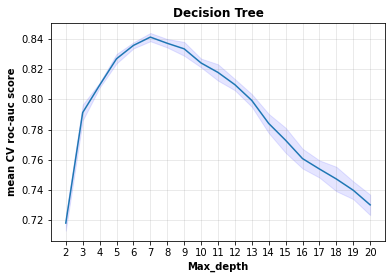

In [27]:
x0 = [i for i in range(2, 21)]
x1 = gridsearch.cv_results_['mean_test_score']
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
ax.fill_between(x0, (x1-ci), (x1+ci), color='b', alpha=.1)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('Decision Tree', weight='bold')
plt.xticks(x0)
plt.xlabel('Max_depth', weight='bold')
plt.ylabel('mean CV roc-auc score', weight='bold')

**SGD Linear Classifier**

In [28]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}
gridsearch = GridSearchCV(SGDClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.11605291, 0.30163159, 0.11127429, 0.08694992, 0.11623325]),
 'std_fit_time': array([0.01326172, 0.04618892, 0.02720671, 0.02518318, 0.01622427]),
 'mean_score_time': array([0.00202293, 0.00159545, 0.00059848, 0.00392218, 0.00372248]),
 'std_score_time': array([0.00404587, 0.00134512, 0.00119696, 0.00605043, 0.006061  ]),
 'param_loss': masked_array(data=['hinge', 'log', 'modified_huber', 'squared_hinge',
                    'perceptron'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'loss': 'hinge'},
  {'loss': 'log'},
  {'loss': 'modified_huber'},
  {'loss': 'squared_hinge'},
  {'loss': 'perceptron'}],
 'split0_test_score': array([0.61285991, 0.61294945, 0.62175039, 0.63061139, 0.59468801]),
 'split1_test_score': array([0.62229176, 0.59831578, 0.61096442, 0.62850514, 0.62834832]),
 'split2_test_score': array([0.65250124, 0.62836064, 0.60034616, 0.60119515, 0.58015509]),
 'split3_test

In [29]:
print('SGD Classifier','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

SGD Classifier 
best parameters: {'loss': 'squared_hinge'} 
best score: 0.6178253388920197


Text(0, 0.5, 'mean CV roc-auc score')

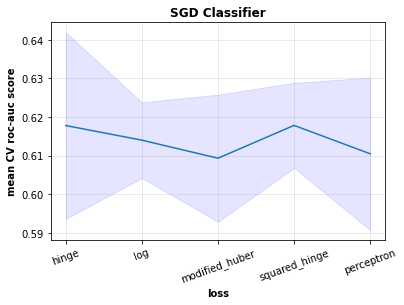

In [30]:
x0 = [i for i in range(1, 6)]
x1 = gridsearch.cv_results_['mean_test_score']
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
ax.fill_between(x0, (x1-ci), (x1+ci), color='b', alpha=.1)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('SGD Classifier', weight='bold')
plt.xticks(x0, labels = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], rotation=20)
plt.xlabel('loss', weight='bold')
plt.ylabel('mean CV roc-auc score', weight='bold')

**Выводы по графикам:**

На первых двух графиках видим, что они выпуклые: т.е с увеличением значения параметра качество сначала растет, затем достигает максимального значения, затем начинает убывать. Возможно, это говорит о переобучении (в дереве) или недообучении (в kNN) и о том, что на тестовой выборке алгоритм постепенно снижает качество. Т.е оптимальное значение параметра скорее всего не будет лежать на границах интервала.
По форме графика для SGD никаких выводов о переобучении сделать нельзя (т.к параметр нечисловой), поэтому на него можно просто посмотреть и сказать, что оптимальный параметр это лосс=squared hinge.

Что вы можете сказать о получившихся графиках?

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [31]:
param_grid = {'n_estimators': [i for i in range (1, 51)]}
gridsearch = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.01592813, 0.02726293, 0.03485084, 0.04937229, 0.06065474,
        0.06839519, 0.08138747, 0.09069452, 0.10788851, 0.11773882,
        0.12599635, 0.14078369, 0.14893093, 0.16068015, 0.17158723,
        0.17552233, 0.18825512, 0.19968038, 0.21448803, 0.22700081,
        0.23576331, 0.24895391, 0.25283608, 0.27161307, 0.28237443,
        0.2944315 , 0.31189504, 0.3173173 , 0.32093801, 0.33257604,
        0.36107569, 0.35932574, 0.36780968, 0.3802495 , 0.39346094,
        0.4064405 , 0.41355419, 0.42676167, 0.43803453, 0.44993792,
        0.44877481, 0.47227936, 0.47698407, 0.49812846, 0.49363289,
        0.51237073, 0.51568928, 0.53889093, 0.54694877, 0.58190565]),
 'std_fit_time': array([0.00091551, 0.00701851, 0.00468521, 0.00402965, 0.0024333 ,
        0.00495176, 0.00379465, 0.00379841, 0.00703669, 0.01243899,
        0.00287077, 0.00946989, 0.00193592, 0.00612902, 0.00424483,
        0.00581109, 0.00432285, 0.00372882, 0.00661771, 0.00371127,
        0.010

Рэндом форест у меня обучается некритично долго, поэтому обучу леса с количеством деревьев от 1 до 50 и посмотрю, на каком значении качество +- стабилизируется.

Text(0, 0.5, 'mean CV roc-auc score')

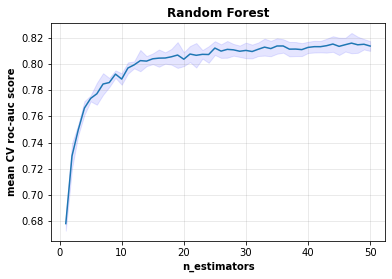

In [32]:
x0 = [i for i in range (1, 51)]
x1 = gridsearch.cv_results_['mean_test_score']
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
ax.fill_between(x0, (x1-ci), (x1+ci), color='b', alpha=.1)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('Random Forest', weight='bold')
plt.xticks()
plt.xlabel('n_estimators', weight='bold')
plt.ylabel('mean CV roc-auc score', weight='bold')

Видим, что с 20 деревьев качество начинает расти очень медленно, поэтому найдем оптимальное значение количества деревьев в промежутке от 20 до 30.

In [33]:
best_score = max(gridsearch.cv_results_['mean_test_score'][20:30])
best_n = 20 + argmax(gridsearch.cv_results_['mean_test_score'][20:30])
print('Random Forest','\nbest n_estimators parameter:', best_n, '\nbest score:', best_score)

Random Forest 
best n_estimators parameter: 24 
best score: 0.8120308537194125


**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=690)

In [35]:
loss=[]

# tqdm here to track learning progress
for n_estimators in tqdm([i for i in range (1, 500)]):
    clf = GradientBoostingClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    log_loss_n = log_loss(y_test, y_pred)
    loss.append(log_loss_n)
min_loss = min(loss[0:500])
best_n = argmin(loss[0:500])

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [16:12<00:00,  1.95s/it]


Text(0, 0.5, 'loss')

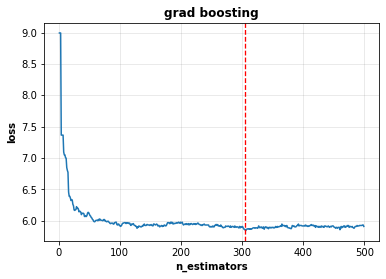

In [36]:
x0 = [i for i in range (1, 500)]
x1 = loss
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
plt.axvline(x=best_n, linestyle='--', color='red',  linewidth=1.3)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('grad boosting', weight='bold')
plt.xticks()
plt.xlabel('n_estimators', weight='bold')
plt.ylabel('loss', weight='bold')

In [40]:
best_score = mean(cross_val_score(GradientBoostingClassifier(n_estimators=best_n), X, y, scoring='roc_auc', cv=5))

In [41]:
print('Gradient Boosting','\nbest n_estimators parameter:', best_n, '\nbest score:', best_score)

Gradient Boosting 
best n_estimators parameter: 305 
best score: 0.865756314051292


При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

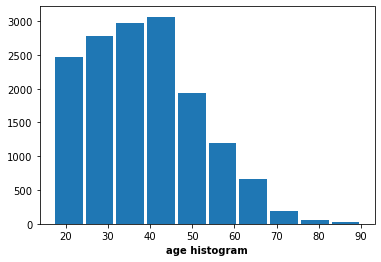

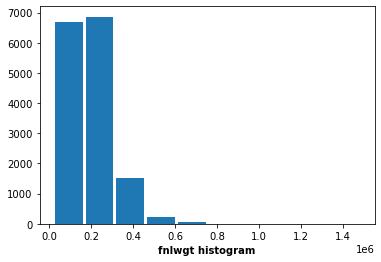

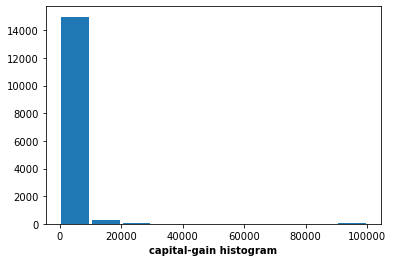

In [42]:
for column in ['age', 'fnlwgt', 'capital-gain']:
    fig, ax = plt.subplots()
    plt.hist(X[column], rwidth=0.9)
    plt.xlabel(column+' histogram', weight='bold')


Признаки имеют разный масштаб. Это должно сильно отразиться на качестве линейных моделей и kNN (тк он работает с вычислением расстояний между объектами). На деревья и их композиции, полагаю, масштабирование повлияет не так сильно. В целом, ожидаю, что поднимется качество при масштабировании.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [43]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X)

,0,1,2,3,4,5
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


**kNN best parameters**

In [44]:
param_grid = {'n_neighbors': [1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000, 15346]}
gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

C:\miniconsa\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\miniconsa\lib\site-packages\sklearn\metrics\_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\miniconsa\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\miniconsa\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\miniconsa\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), es

{'mean_fit_time': array([0.10951686, 0.11296673, 0.11270385, 0.10489554, 0.10829706,
        0.12323895, 0.10996156, 0.11196451, 0.10896716, 0.11634655,
        0.00099626, 0.00138125]),
 'std_fit_time': array([0.00734938, 0.00574667, 0.00787377, 0.00434365, 0.00677599,
        0.00773914, 0.00554493, 0.00576765, 0.00761628, 0.00636042,
        0.00063068, 0.00050117]),
 'mean_score_time': array([7.43679047e-02, 8.83355141e-02, 1.04159451e-01, 1.25404644e-01,
        1.70742655e-01, 2.51764011e-01, 3.30351686e-01, 8.92994452e-01,
        1.46947913e+00, 4.59902191e+00, 5.88409896e+00, 1.01222992e-03]),
 'std_score_time': array([0.00930661, 0.0064243 , 0.00696995, 0.00436592, 0.00889155,
        0.00910639, 0.01351235, 0.04046986, 0.04654519, 0.14102691,
        0.13733436, 0.00064226]),
 'param_n_neighbors': masked_array(data=[1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000,
                    15346],
              mask=[False, False, False, False, False, False, False, False,
       

In [45]:
print('kNN','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

kNN 
best parameters: {'n_neighbors': 50} 
best score: 0.8338088519890483


In [46]:
param_grid = {'n_neighbors': [i for i in range(20, 501, 10)]}
gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.1063509 , 0.11055565, 0.11897545, 0.11058092, 0.10363531,
        0.109902  , 0.10708632, 0.10656614, 0.12328386, 0.10936575,
        0.11164451, 0.1035728 , 0.11484303, 0.10650115, 0.10268245,
        0.10304551, 0.10413547, 0.10031404, 0.10897641, 0.10315166,
        0.1085526 , 0.1135139 , 0.11262736, 0.10373969, 0.11078992,
        0.10910406, 0.11051078, 0.11268539, 0.10433617, 0.10672507,
        0.10798917, 0.10851202, 0.10810919, 0.10929785, 0.10951538,
        0.10554991, 0.10193243, 0.10591383, 0.11049337, 0.10790248,
        0.10671606, 0.1102973 , 0.10808578, 0.10750442, 0.10712085,
        0.10930681, 0.10591989, 0.10751295, 0.1069191 ]),
 'std_fit_time': array([0.00564979, 0.00443605, 0.00534781, 0.00640307, 0.00717192,
        0.00599086, 0.00587017, 0.00398295, 0.01276227, 0.00455652,
        0.00913762, 0.00456625, 0.00802436, 0.00600414, 0.00400845,
        0.00480092, 0.0034469 , 0.00366016, 0.0046403 , 0.00627597,
        0.00677637, 0.002

In [47]:
print('KNN','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

KNN 
best parameters: {'n_neighbors': 40} 
best score: 0.8340402475560282


In [48]:
param_grid = {'n_neighbors': [i for i in range(40, 51)]}
gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.11129942, 0.11108494, 0.10631652, 0.10631499, 0.1099194 ,
        0.11010132, 0.10251412, 0.10909901, 0.10790343, 0.10671339,
        0.10882587]),
 'std_fit_time': array([3.86739317e-03, 1.35003647e-03, 4.21197465e-03, 2.86240840e-03,
        2.47232182e-03, 1.94769806e-03, 3.27988830e-03, 4.98554388e-03,
        2.79712260e-03, 8.74056949e-07, 3.05896136e-03]),
 'mean_score_time': array([0.21044726, 0.21185241, 0.20765648, 0.20942874, 0.21521487,
        0.21782131, 0.22002254, 0.21982217, 0.22340064, 0.22041154,
        0.22619462]),
 'std_score_time': array([0.01059821, 0.00549749, 0.00514132, 0.00372241, 0.00402236,
        0.00528032, 0.00761302, 0.00530953, 0.00710891, 0.00432459,
        0.0060624 ]),
 'param_n_neighbors': masked_array(data=[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object)

In [49]:
print('KNN','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

KNN 
best parameters: {'n_neighbors': 44} 
best score: 0.8342240437766663


Качество улучшилось! Было 0.6407

**Decision Tree best parameters**

In [50]:
param_grid = {'max_depth': [1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000, 15346]}
gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.00397038, 0.00736432, 0.01337924, 0.02233682, 0.03191624,
        0.03450518, 0.03489852, 0.03431058, 0.03469763, 0.03471022,
        0.03450975, 0.03430133]),
 'std_fit_time': array([2.09211454e-05, 7.78412751e-04, 4.92480446e-04, 4.87228760e-04,
        6.26231487e-04, 4.83537223e-04, 6.31579177e-04, 4.85622068e-04,
        7.38790027e-04, 4.00950968e-04, 4.90761549e-04, 4.97291902e-04]),
 'mean_score_time': array([0.00200315, 0.00200787, 0.00198045, 0.00199666, 0.00219221,
        0.00239596, 0.00218263, 0.00241561, 0.00219984, 0.00219498,
        0.00198035, 0.00220203]),
 'std_score_time': array([2.86964865e-05, 6.41005553e-04, 6.31284507e-04, 5.92238661e-06,
        3.95443312e-04, 4.84383348e-04, 4.06762153e-04, 4.90288673e-04,
        3.91271443e-04, 3.99304433e-04, 2.35329645e-05, 4.18359243e-04]),
 'param_max_depth': masked_array(data=[1, 2, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000,
                    15346],
              mask=[False, False, Fal

In [51]:
print('Decision tree','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

Decision tree 
best parameters: {'max_depth': 5} 
best score: 0.8268388514895324


In [52]:
param_grid = {'max_depth': [i for i in range(2, 21)]}
gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.00718064, 0.00917659, 0.01177411, 0.01324172, 0.01535783,
        0.01775713, 0.01933661, 0.02114644, 0.02233915, 0.02432628,
        0.02531939, 0.02692723, 0.0283247 , 0.03092642, 0.02951341,
        0.03013811, 0.03131423, 0.03211775, 0.03312011]),
 'std_fit_time': array([0.00074586, 0.00039681, 0.00073801, 0.00040396, 0.00048713,
        0.00074119, 0.00050841, 0.00043154, 0.00048916, 0.00049584,
        0.00049049, 0.0006309 , 0.00049049, 0.00063249, 0.00048244,
        0.00041128, 0.00078396, 0.00042552, 0.00074438]),
 'mean_score_time': array([0.00199461, 0.00259213, 0.00239706, 0.00200281, 0.00218825,
        0.00199342, 0.00219541, 0.00199256, 0.00219479, 0.00221496,
        0.00239573, 0.00199571, 0.00219493, 0.00239353, 0.00239329,
        0.00277715, 0.00259495, 0.00198388, 0.0023931 ]),
 'std_score_time': array([6.21719590e-07, 7.95806238e-04, 7.97420099e-04, 1.44045868e-05,
        3.84789310e-04, 2.41220226e-05, 3.71668532e-04, 3.82541106e-06,


In [53]:
print('Decision tree','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

Decision tree 
best parameters: {'max_depth': 7} 
best score: 0.8414035504977482


Качество улучшилось, но не сильно. Было 0.8413

**SGD Linear Classifier best parameters**

In [55]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}
gridsearch = GridSearchCV(SGDClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.04148035, 0.03709993, 0.05744634, 0.07998357, 0.03410859]),
 'std_fit_time': array([0.01540912, 0.00486057, 0.00771487, 0.0147954 , 0.00644457]),
 'mean_score_time': array([0.00199537, 0.00199485, 0.00239377, 0.00199537, 0.00179644]),
 'std_score_time': array([1.09292812e-03, 6.30675630e-04, 4.88869803e-04, 4.62310777e-07,
        7.46533633e-04]),
 'param_loss': masked_array(data=['hinge', 'log', 'modified_huber', 'squared_hinge',
                    'perceptron'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'loss': 'hinge'},
  {'loss': 'log'},
  {'loss': 'modified_huber'},
  {'loss': 'squared_hinge'},
  {'loss': 'perceptron'}],
 'split0_test_score': array([0.81427231, 0.81680371, 0.81275637, 0.7882771 , 0.73531517]),
 'split1_test_score': array([0.82158373, 0.82324704, 0.82168438, 0.81215716, 0.67562406]),
 'split2_test_score': array([0.81096545, 0.81994494, 0.78738453, 0.79918751,

In [56]:
print('SGD Classifier','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_)

SGD Classifier 
best parameters: {'loss': 'log'} 
best score: 0.8212405325841997


Качество сильно улучшилось. Было 0.6178

**Random Forest best parameters**

In [57]:
param_grid = {'n_estimators': [i for i in range (1, 51)]}
gridsearch = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
gridsearch.cv_results_

{'mean_fit_time': array([0.01377077, 0.02493205, 0.03501296, 0.04486804, 0.06143513,
        0.06981988, 0.08338523, 0.09196649, 0.10291553, 0.11688657,
        0.12425013, 0.13781829, 0.15557179, 0.15817809, 0.17453284,
        0.18031278, 0.19907069, 0.20646424, 0.20525093, 0.22042265,
        0.22959366, 0.24572124, 0.26348948, 0.27505665, 0.28903074,
        0.28742657, 0.29959197, 0.31035457, 0.32114344, 0.33171554,
        0.34647117, 0.35661612, 0.36184716, 0.37895122, 0.38616686,
        0.40411744, 0.40690308, 0.423873  , 0.4326303 , 0.44003177,
        0.45837355, 0.46168094, 0.47591724, 0.48232946, 0.49606853,
        0.5092463 , 0.51701083, 0.5337966 , 0.53776178, 0.55490408]),
 'std_fit_time': array([0.00182067, 0.00177112, 0.00066341, 0.00064954, 0.00205361,
        0.00126753, 0.00364437, 0.00116111, 0.00347895, 0.00416598,
        0.00256505, 0.00575449, 0.00907544, 0.00887423, 0.01046041,
        0.00400267, 0.0092137 , 0.00858671, 0.00263124, 0.00482077,
        0.004

Text(0, 0.5, 'mean CV roc-auc score')

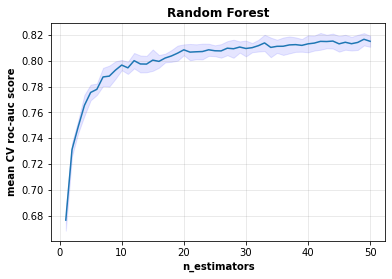

In [58]:
x0 = [i for i in range (1, 51)]
x1 = gridsearch.cv_results_['mean_test_score']
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
ax.fill_between(x0, (x1-ci), (x1+ci), color='b', alpha=.1)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('Random Forest', weight='bold')
plt.xticks()
plt.xlabel('n_estimators', weight='bold')
plt.ylabel('mean CV roc-auc score', weight='bold')

In [59]:
best_score = max(gridsearch.cv_results_['mean_test_score'][20:30])
best_n = 20 + argmax(gridsearch.cv_results_['mean_test_score'][20:30])
print('Random Forest','\nbest n_estimators parameter:', best_n, '\nbest score:', best_score)

Random Forest 
best n_estimators parameter: 28 
best score: 0.8107806433862474


Text(0, 0.5, 'mean CV roc-auc score')

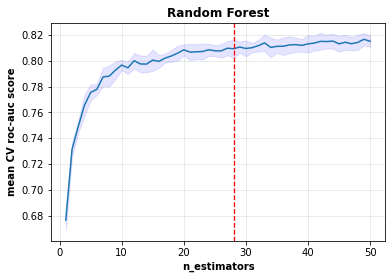

In [60]:
x0 = [i for i in range (1, 51)]
x1 = gridsearch.cv_results_['mean_test_score']
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
plt.axvline(x=best_n, linestyle='--', color='red',  linewidth=1.3)
ax.fill_between(x0, (x1-ci), (x1+ci), color='b', alpha=.1)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('Random Forest', weight='bold')
plt.xticks()
plt.xlabel('n_estimators', weight='bold')
plt.ylabel('mean CV roc-auc score', weight='bold')

Качество упало, но не сильно

**Gradient Boosting best parameters**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=690)

In [62]:
loss=[]

# tqdm here to track learning progress
for n_estimators in tqdm([i for i in range (1, 500)]):
    clf = GradientBoostingClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    log_loss_n = log_loss(y_test, y_pred)
    loss.append(log_loss_n)
min_loss = min(loss[0:500])
best_n = argmin(loss[0:500])

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [16:17<00:00,  1.96s/it]


Text(0, 0.5, 'loss')

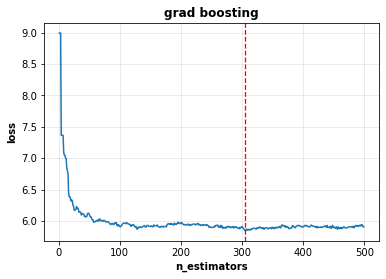

In [63]:
x0 = [i for i in range (1, 500)]
x1 = loss
# confidence interval
ci = gridsearch.cv_results_['std_test_score']

fig, ax = plt.subplots()
ax.plot(x0,x1)
plt.axvline(x=best_n, linestyle='--', color='red',  linewidth=1.3)

ax.grid(color='grey', alpha=0.2, linestyle='-')

plt.title('grad boosting', weight='bold')
plt.xticks()
plt.xlabel('n_estimators', weight='bold')
plt.ylabel('loss', weight='bold')

In [65]:
best_score = mean(cross_val_score(GradientBoostingClassifier(n_estimators=best_n), X, y, scoring='roc_auc', cv=5))
#clf = GradientBoostingClassifier(n_estimators=best_n)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#best_score = roc_auc_score(y_test, y_pred)

In [66]:
print('Gradient Boosting','\nbest n_estimators parameter:', best_n, '\nbest score:', best_score)

Gradient Boosting 
best n_estimators parameter: 305 
best score: 0.8658372073191808


Качество поднялось немного

Изменилось ли качество у некоторых алгоритмов?

Подтвердили гипотезу: у линейной модели и KNN сильно поднялось качество. У деревьев и композиций - не сильно изменилось.

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [68]:
param_grid = {'n_neighbors': [5, 10, 20, 40, 50, 60, 100, 500, 1000, 5000], 'metric':['euclidean','manhattan','chebyshev']}
gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
print('kNN Classifier','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_,
     '\nВремя обучения:', gridsearch.cv_results_['mean_fit_time'].sum(), 'sec')

kNN Classifier 
best parameters: {'metric': 'manhattan', 'n_neighbors': 40} 
best score: 0.8341041331495548 
Время обучения: 3.2160448074340815 sec


In [69]:
param_grid = {'max_depth': [i for i in range(1, 16)], 'criterion':['gini', 'entropy']}
gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
print('Desicion Tree Classifier','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_,
      '\nВремя обучения:', gridsearch.cv_results_['mean_fit_time'].sum(), 'sec')

Desicion Tree Classifier 
best parameters: {'criterion': 'entropy', 'max_depth': 8} 
best score: 0.8420448080533858 
Время обучения: 0.6301230430603025 sec


In [70]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'penalty':['l2', 'l1', 'elasticnet']}
gridsearch = GridSearchCV(SGDClassifier(), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
print('SGD Classifier','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_,
      '\nВремя обучения:', gridsearch.cv_results_['mean_fit_time'].sum(), 'sec')

SGD Classifier 
best parameters: {'loss': 'log', 'penalty': 'l2'} 
best score: 0.8229998095662397 
Время обучения: 0.7828892707824706 sec


In [71]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_features':['auto', 'sqrt', 'log2']}
gridsearch = GridSearchCV(RandomForestClassifier(n_estimators=29), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
print('Random Forest Classifier','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_,
      '\nВремя обучения:', gridsearch.cv_results_['mean_fit_time'].sum(), 'sec')

Random Forest Classifier 
best parameters: {'criterion': 'entropy', 'max_features': 'auto'} 
best score: 0.8127736271547752 
Время обучения: 2.2462220191955566 sec


In [73]:
param_grid = {'criterion': ['friedman_mse', 'squared_error'], 'max_features':['sqrt', 'log2']}
gridsearch = GridSearchCV(GradientBoostingClassifier(n_estimators=304), param_grid, scoring='roc_auc', cv=5)

gridsearch.fit(X, y)
print('Gradient Boosting Classifier','\nbest parameters:', gridsearch.best_params_, '\nbest score:', gridsearch.best_score_,
      '\nВремя обучения:', gridsearch.cv_results_['mean_fit_time'].sum(), 'sec')

C:\miniconsa\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\miniconsa\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\miniconsa\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\miniconsa\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\miniconsa\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\miniconsa\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\miniconsa\lib\site-packages\sklearn\tree\_classes.py", line 350, in fit
    criterion = CRITERIA_REG[s

Gradient Boosting Classifier 
best parameters: {'criterion': 'friedman_mse', 'max_features': 'sqrt'} 
best score: 0.8660831580835702 
Время обучения: 2.668848514556885 sec


**Лучшее качество: Gradient Boosting Classifier**

Какой из алгоритмов имеет наилучшее качество? 

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Самый быстрый: Decision Tree 

Самый медленный: KNN

KNN требуется много времени, чтобы рассчитать расстояния между всеми объектами

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [74]:
data.columns 

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', '>50K,<=50K'],
      dtype='object')

In [75]:
data_num.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [76]:
cat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
data_cat = pd.get_dummies(data, columns=cat, drop_first=True).iloc[:, 7:]
data_cat


,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
16276,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
16277,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
16278,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [77]:
data_new = pd.DataFrame(np.concatenate((data_cat.to_numpy(), X), axis=1))
data_new

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


In [78]:
mean(cross_val_score(KNeighborsClassifier(n_neighbors=40, metric='manhattan'), data_new, y, scoring='roc_auc', cv=5))

0.8906963183035848

kNN: Качество улучшилось

In [79]:
mean(cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=8), data_new, y, scoring='roc_auc', cv=5))

0.8903020323497122

Дерево: качество улучшилось

In [81]:
mean(cross_val_score(SGDClassifier(loss='log', penalty='elasticnet'), data_new, y, scoring='roc_auc', cv=5))

0.9014953212325668

SGD: качество улучшилось

In [82]:
mean(cross_val_score(RandomForestClassifier(n_estimators=29, criterion='entropy', max_features='sqrt'), data_new, y, scoring='roc_auc', cv=5))

0.8935403582624675

Random Forest: качество улучшилось

In [83]:
mean(cross_val_score(GradientBoostingClassifier(n_estimators=304, criterion='friedman_mse', max_features='sqrt'), data_new, y, scoring='roc_auc', cv=5)) 

0.9197762984486293

Бустинг: качество улучшилось

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Лучший классификатор: **Gradient Boosting**. В прошлом пункте был он же.
    

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [84]:
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)
X

array([[ 1.00000000e+00, -3.42918504e-01,  9.00258021e-01, ...,
         4.78473648e-02, -3.47408553e-01,  2.52245244e+00],
       [ 1.00000000e+00,  1.14760125e-01,  1.06827133e-02, ...,
         4.78473648e-02,  1.62257626e-02,  5.50240068e-03],
       [ 1.00000000e+00, -1.90358961e-01, -1.06280262e-01, ...,
         4.78473648e-02,  1.62257626e-02,  5.50240068e-03],
       ...,
       [ 1.00000000e+00, -8.76876904e-01, -7.96852927e-01, ...,
         4.78473648e-02,  1.62257626e-02,  5.50240068e-03],
       [ 1.00000000e+00,  1.56407578e+00,  7.48381146e-01, ...,
         4.78473648e-02,  1.62257626e-02,  5.50240068e-03],
       [ 1.00000000e+00, -4.19198275e-01, -1.22374144e+00, ...,
         2.00117040e+01,  1.52733291e+00,  1.16569074e-01]])

In [85]:
X.shape[1] # number of features 

28

In [86]:
# knn
# filtration

score=[]
for k_features in range(10,29):
    X_new = SelectKBest(mutual_info_classif, k=k_features).fit_transform(X, y)
    score.append(mean(cross_val_score(KNeighborsClassifier(n_neighbors=40, metric='manhattan'), X_new, y, scoring='roc_auc', cv=5)))
print('number of features=', 10+argmax(score), '\nbest CV score=', max(score))
    

number of features= 18 
best CV score= 0.8380635358514039


In [87]:
data_new = pd.DataFrame(np.concatenate((data_cat.to_numpy(), X_new), axis=1))
mean(cross_val_score(KNeighborsClassifier(n_neighbors=40, metric='manhattan'), data_new, y, scoring='roc_auc',cv=5))

0.8896495503857915

Качество хуже (немношк)

In [88]:
# decision tree
# RFE

score=[]
for k_best in range(10,29):
    X_new = RFE(DecisionTreeClassifier(criterion='entropy', max_depth=8), n_features_to_select=k_best, step=30).fit_transform(X, y)
    score.append(mean(cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=8), X_new, y, scoring='roc_auc',cv=5)))
print('number of features=', 10+argmax(score), '\nbest CV score=', max(score))

number of features= 16 
best CV score= 0.8406471875792793


In [89]:
data_new = pd.DataFrame(np.concatenate((data_cat.to_numpy(), X_new), axis=1))
mean(cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=8), data_new, y, scoring='roc_auc',cv=5))

0.8889095484390623

качество хуже (тоже немношк)

In [90]:
# SGD
# regularization 

X_new = SelectFromModel(SGDClassifier(loss='log', penalty='elasticnet')).fit_transform(X, y)
score=mean(cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=8), X_new, y, scoring='roc_auc', cv=5))
print('number of features=', X_new.shape[1], '\nbest CV score=', score)

number of features= 9 
best CV score= 0.843888354195353


In [91]:
data_new = pd.DataFrame(np.concatenate((data_cat.to_numpy(), X_new), axis=1))
mean(cross_val_score(SGDClassifier(loss='log', penalty='elasticnet'), data_new, y, scoring='roc_auc', cv=5))

0.9059482246418062

Качество лучше

In [92]:
# Random Forest
# RFE
score=[]
for k_best in range(10,29):
    X_new = RFE(RandomForestClassifier(n_estimators=29, criterion='entropy', max_features='sqrt'), n_features_to_select=k_best, step=30).fit_transform(X, y)
    score.append(mean(cross_val_score(RandomForestClassifier(n_estimators=29, criterion='entropy', max_features='sqrt'), X_new, y, scoring='roc_auc', cv=5)))
print('number of features=', 10+argmax(score), '\nbest CV score=', max(score))

number of features= 18 
best CV score= 0.813267659979011


In [93]:
data_new = pd.DataFrame(np.concatenate((data_cat.to_numpy(), X_new), axis=1))
mean(cross_val_score(RandomForestClassifier(n_estimators=29, criterion='entropy', max_features='sqrt'), data_new, y, scoring='roc_auc', cv=5))

0.894050874933404

Качество немношк поднялось 

In [94]:
# Gradient Boosting 
# filtration

score=[]
for k_features in range(10,29):
    X_new = SelectKBest(mutual_info_classif, k=k_features).fit_transform(X, y)
    score.append(mean(cross_val_score(GradientBoostingClassifier(n_estimators=304, criterion='friedman_mse', max_features='sqrt'), X_new, y, scoring='roc_auc', cv=5)))
print('number of features=', 10+argmax(score), '\nbest CV score=', max(score))

number of features= 11 
best CV score= 0.8654148960002809


In [95]:
data_new = pd.DataFrame(np.concatenate((data_cat.to_numpy(), X_new), axis=1))
mean(cross_val_score(GradientBoostingClassifier(n_estimators=304, criterion='friedman_mse', max_features='sqrt'), data_new, y, scoring='roc_auc', cv=5)) # waiting 

0.9195579871633776

Качество почти не изменилось (немношк упало)

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [97]:
X_train, X_test, y_train, y_test = train_test_split(data_new, y, test_size=0.3, random_state=690)

In [99]:
clf1 = GradientBoostingClassifier(n_estimators=304, criterion='friedman_mse', max_features='sqrt').fit(X_train, y_train)
clf2 = SGDClassifier(loss='log', penalty='elasticnet').fit(X_train, y_train)

score=[]
for alpha in [n * 1/10 for n in range(0,11)]:
    y_pred = alpha * clf1.predict(X_test) + (1-alpha) * clf2.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    score.append(roc_auc)

print('alpha=', argmax(score)*0.1, '\nbest score=', max(score))

alpha= 0.6000000000000001 
best score= 0.8077436080272413


На тестовой выборке чекнули качество и получили, что оно ниже, чем в последних построенных моделях. Там везде больше 0.8

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

**Общие выводы:**

1) KNN, Random Forest и Gradient boosting (более сложные модели) в целом обучаются дольше, чем SGD и дерево. 

2) Значение гиперпараметра сильно влияет на качество модели (это видно, например, на графиках)

3) Есть модели, чувствительные к масштабу признаков: линейные и KNN - при масштабировании качество очень сильно растет

4) При добавлении категориальных признаков качество растет 

5) При Feature engineering качество изменяется относительно слабо. Надо искать гиперпараметры для методов, но не факт, что это поможет. 

6) Лучшее качество из всего, что было обучено - у градиентного бустинга 0.9198
